In [0]:
#support python 2&3
from __future__ import division, print_function, unicode_literals

#common imports
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')

#make notebook's output stable across runs
np.random.seed(42)

#Pretty Figures
%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

#Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [0]:
tp = os.path.join('datasets', 'titanic')

In [0]:
def load_data(filename):
    return pd.read_csv(filename)

In [0]:
train_data = load_data('train.csv')
test_data = load_data('test.csv')

In [9]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The attributes:
* **Survived** : survived or not. the label

In [10]:
train_data.info() #Age, #Cabin, #Embarked have some null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [0]:
cat_att = list(train_data.select_dtypes(include=['object']).columns)
num_att = list(train_data.select_dtypes(include=['float64', 'int64']).columns)

In [12]:
train_data.describe() #only 38% survived. close enough to 40% so accuracy will be a resonable metric
#more older people than younger 
#fare was high for the time period

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [13]:
td = train_data[['Embarked', 'Sex', 'Pclass', 'Survived']].apply(pd.value_counts).T.fillna(0)
#C=Cherbourg, Q=Queenstown, S=Southampton -- cities
td.style.background_gradient('copper')

/usr/local/lib/python3.6/dist-packages/pandas/core/indexes/api.py:87: RuntimeWarning: '<' not supported between instances of 'str' and 'int', sort order is undefined for incomparable objects
  result = result.union(other)


,C,Q,S,female,male,3,1,2,0
Embarked,168,77,644,0,0,0,0,0,0
Sex,0,0,0,314,577,0,0,0,0
Pclass,0,0,0,0,0,491,216,184,0
Survived,0,0,0,0,0,0,342,0,549


In [0]:
from collections import Counter

def detect_outliers(df, n, features):
    
    outlier_indices = []
    for col in features:
        Q1 = df[col].quantile(q=0.25)
        Q3 = df[col].quantile(q=0.75)
        IQR = Q3-Q1        
        step = 1.5*IQR
        outlier_list = df[(df[col]<Q1-step) | (df[col]>Q3+step)].index
        outlier_indices.extend(outlier_list)
    
    outlier_indices = Counter(outlier_indices)
    #records having multiple outliers 
    multi_outlier = list(k for k,v in outlier_indices.items() if v>n)
    return multi_outlier

In [15]:
outliers_todrop = detect_outliers(train_data,2,['Age', 'SibSp', 'Parch', 'Fare'])
train_data.loc[outliers_todrop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
745,746,0,1,"Crosby, Capt. Edward Gifford",male,70.0,1,1,WE/P 5735,71.00,B22,S
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S


In [16]:
#train_data = train_data.drop(outliers_todrop, axis=0).reset_index(drop=True)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [17]:
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [18]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [19]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [0]:
#Feature Analysis 

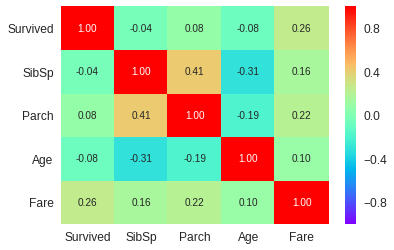

In [21]:
sns.heatmap(train_data[['Survived', 'SibSp', 'Parch', 'Age', 'Fare']].corr(), annot=True, 
                cmap='rainbow', fmt='.2f')
plt.show()
#Only Fare shows some correalation

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


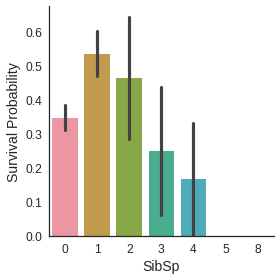

In [23]:
#Siblings
p = sns.factorplot(x='SibSp', y='Survived', data=train_data, kind='bar')
p.set_ylabels('Survival Probability')
#Having fewer siblings increase chances of survival

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


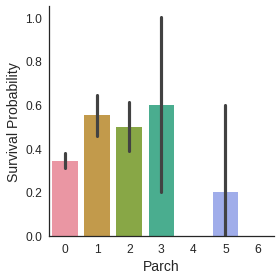

In [24]:
#Parents
p = sns.factorplot(x='Parch', y='Survived', data=train_data, kind='bar')
p = p.set_ylabels('Survival Probability')
#Medium Sized family has a better chance of survivng 

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


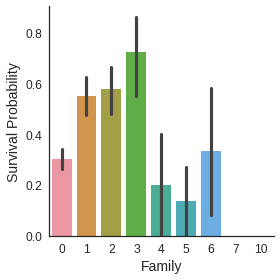

In [25]:
#total family size
train_data['Family'] = train_data.SibSp + train_data.Parch
p = sns.factorplot(x='Family', y='Survived', data=train_data, kind='bar')
p = p.set_ylabels('Survival Probability')
#Again there is clear peak for medium sized families
#Family with more than 3 members have a lesser chance of surviving 
#Similary Indiviudals travelling alone have a lesser chance of surviving

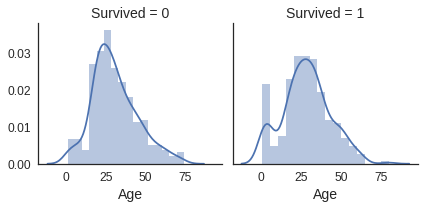

In [26]:
#Age
p = sns.FacetGrid(col='Survived', data=train_data)
p = p.map(sns.distplot, 'Age')

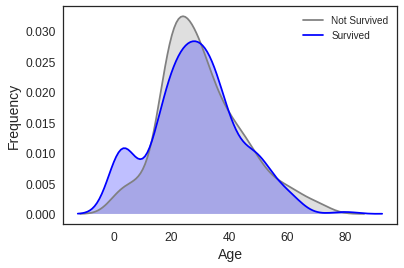

In [28]:
p = sns.kdeplot(train_data.Age[(train_data.Survived==0)&(train_data.Age.notnull())], color='grey', shade=True)
p = sns.kdeplot(train_data.Age[(train_data.Survived==1)&(train_data.Age.notnull())], color='blue', shade=True)
p.set_xlabel('Age')
p.set_ylabel('Frequency')
p = p.legend(['Not Survived', 'Survived'])
#babies and very young childrens have a higher chance of surviving 
#Age 60-80 less survived 

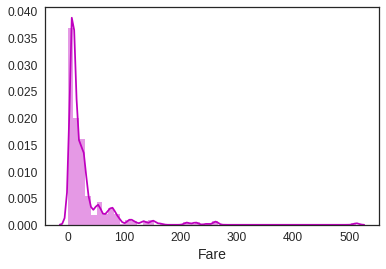

In [29]:
#Fare
p = sns.distplot(train_data.Fare, color='m')

In [0]:
train_data['AgeBucket'] = train_data.Age//15*15
train_data[['AgeBucket', 'Survived']].groupby(['AgeBucket']).mean()

train_data['AgeBins'] = pd.cut(train_data.Age, bins=[0, 14, 30, 45, 60, 75, 100], include_lowest=True, 
                                 labels=['0-15', '15-30', '30-45', '45-60', '60-75','>75'])
train_data[['AgeBins','Survived']].groupby(['AgeBins']).mean()

train_data['RelativesAboard'] = train_data.SibSp + train_data.Parch
train_data[['RelativesAboard', 'Survived']].groupby(['RelativesAboard']).mean()

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

imputer = SimpleImputer(strategy='median')

num_pipeline = Pipeline([#('select_numeric', DataFrameSelector(['Age', 'SibSp', 'Parch', 'Fare'])),
                         ('imputer', SimpleImputer(strategy='median')),
                         ('scaler', StandardScaler()),
                        ])


In [0]:
#num_pipeline.fit_transform(train_data)

In [0]:
#Imputer for string categorical columns. Simpleimputer only works on Numerical data
from sklearn.base import BaseEstimator, TransformerMixin

class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X], index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [0]:
from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline([#('select_cat', DataFrameSelector(['Pclass','Sex','Embarked'])),
                        ('imputer', MostFrequentImputer()),
                        ('cat_encoder', OneHotEncoder()),
                        ])

#cat_pipeline.fit_transform(train_data)

In [0]:
from sklearn.compose import ColumnTransformer

num_att = ['Age', 'SibSp', 'Parch', 'Fare']
cat_att = ['Pclass','Sex','Embarked']
preprocess_pipeline = ColumnTransformer([('num_pipeline', num_pipeline, num_att),
                                   ('cat_pipeline', cat_pipeline, cat_att),
                                  ])

In [0]:
X_train = preprocess_pipeline.fit_transform(train_data)
X_train 

In [0]:
y_train = train_data.Survived

In [0]:
class perf_metrics(object):
    '''Custom class that creates an object using model, data features and label'''
    def __init__(self,model,features,label):
        self.model = model
        self.features = features
        self.label = label
    def getModel(self):
        return self.model
    def getFeatures(self):
        return self.features
    def getLabel(self):
        return self.label
    def __str__(self):
        return 'Model '+ str(self.model) + '\n\n' + 'features\n'+ str(pd.DataFrame(self.features))\
                 + '\n\nLabel \n' + str(pd.DataFrame(self.label)) 
    def plot_prec_recall_vs_tresh(self,precisions, recalls, thresholds):
        plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
        plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
        plt.xlabel('Threshold')
        plt.legend(loc='upper left')
        plt.ylim([0,1])
    def pred_prob(self,k=3,method=None):
        if method=='cross_val':
            y_pred = cross_val_predict(self.model,self.features,self.label.ravel(),cv=k)
            y_prob = cross_val_predict(self.model,self.features,self.label.ravel(),cv=k, method='predict_proba')  
            scores = cross_val_score(estimator=self.model,X=self.features,y=self.label.ravel(),cv=k)
            return y_pred, y_prob, scores
        else:
            y_pred = self.model.predict(self.features)
            y_prob = self.model.predict_proba(self.features)
            return y_pred, y_prob
        
    def show_confusion(self,pred):
        cm = confusion_matrix(self.label,pred)
        ax= plt.subplot()
        sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
        # labels, title and ticks
        ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); ax.set_title('Confusion Matrix'); 
        ax.xaxis.set_ticklabels(['False', 'True']); ax.yaxis.set_ticklabels(['False', 'True']);
        
    def show_roc(self,prob):
        fpr, tpr, threshold = roc_curve(self.label, prob[:,1])
        roc_auc = auc(fpr, tpr)
        #Plot ROC Curve
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--'); plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('Receiver operating characteristic')
        plt.legend(loc="lower right"); plt.show()
        return roc_auc
    
    def show_prec_rec(self,roc_auc,prob,pred):
        recall = recall_score(self.label,pred)
        print('recall',recall)
        macro_Precision = precision_score(self.label,pred, average='macro')
        micro_Precision = precision_score(self.label,pred, average='micro')
        weighted_Precision = precision_score(self.label,pred, average='weighted')
        print('macro_Precision={} micro_Precision={} weighted_Precision={}'.format(macro_Precision,micro_Precision,weighted_Precision))
        f1 = f1_score(self.label, pred)
        average_precision = average_precision_score(self.label, prob[:,1])
        pre, rec, tre = precision_recall_curve(self.label.ravel(),prob[:,1])
        #Plot Precision-Recall Curve
        plt.step(rec, pre, color='b', alpha=0.2, where='post')
        plt.fill_between(rec, pre, step='post', alpha=0.2, color='b')
        plt.xlabel('Recall'); plt.ylabel('Precision'); plt.ylim([0.0, 1.05]); plt.xlim([0.0, 1.0]);
        plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
        print('f1_score=%.3f auc=%.3f average_precision=%.3f' % (f1, roc_auc, average_precision))
        # plot no skill
        plt.plot([0, 1], [0.5, 0.5], linestyle='--')
        # plot the roc curve for the model
        plt.plot(rec, pre, marker='.')
        fig1 = plt.figure()
        self.plot_prec_recall_vs_tresh(pre, rec, tre)
        plt.show()
        
    def show_metrics(self):
        y_pred, y_prob = self.pred_prob()
        print(classification_report(self.label,y_pred))
        print('accuracy',accuracy_score(self.label,y_pred))
        self.show_confusion(y_pred)
        roc_auc = self.show_roc(y_prob) 
        self.show_prec_rec(roc_auc, prob=y_prob, pred=y_pred)       
    
    def cross_val_metrics(self,k=5):
        '''Accpets k as folds'''
        y_pred, y_prob, scores = self.pred_prob(method='cross_val',k=k)
        print('cross_validation_scores',scores)
        print('\n')
        print(classification_report(self.label,y_pred))
        print('accuracy',accuracy_score(self.label,y_pred))
        self.show_confusion(y_pred)
        roc_auc = self.show_roc(y_prob) 
        self.show_prec_rec(roc_auc, prob=y_prob, pred=y_pred)

In [0]:
def train_test(data): 
    from sklearn.model_selection import StratifiedShuffleSplit
    from imblearn.over_sampling import SMOTE
    
    np.random.seed(14)
    X = data.iloc[:,data.columns!='poi']
    y = np.array(data.iloc[:,data.columns=='poi'])   
    X = StandardScaler().fit_transform(X)   
    sss = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=42)
    sss.get_n_splits(X, y)
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    sm = SMOTE(random_state=14, ratio=1)
    X_train_res, y_train_res = sm.fit_sample(X_train,y_train.ravel())
    return X_train_res, y_train_res, X_test, y_test.ravel()

In [0]:
# A parameter grid for XGBoost
import time
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from xgboost import XGBClassifier

parameters = {'objective':['binary:logistic'],
              'gamma': [0.3, 0.5],
              'learning_rate': [0.05, 0.1], #`eta` value
              'max_depth': [3, 4, 5],
              'min_child_weight': [3,4],
              'silent': [1],
              'subsample': [0.8,1],
              'colsample_bytree': [0.8, 1.0],
              'n_estimators': [50, 75,100] #number of trees
              }

xgb_model = XGBClassifier(nthread=-1)
clf_xgb_tuned = GridSearchCV(xgb_model, parameters, n_jobs=5, 
                   cv=StratifiedKFold(n_splits=5, shuffle=True), 
                   scoring='roc_auc',
                   verbose=2, refit=True)
# Here we go
start_time = time.time() # timing starts from this point for "start_time" variable
clf_xgb_tuned.fit(X_train, y_train)

In [0]:
clf_xgb_tuned.best_params_

In [0]:
clf_xgb_tuned.best_score_

In [0]:
clf_xgb_tuned.best_params_

In [0]:
#train classifiers
from sklearn.svm import SVC

svm_clf = SVC(gamma='auto')
svm_clf.fit(X_train, y_train)

In [0]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

In [0]:
X_test = preprocess_pipeline.transform(test_data)
y_pred = svm_clf.predict(X_test)

In [0]:
from sklearn.ensemble import RandomForestClassifier


rf_clf = RandomForestClassifier(random_state=42)
rf_scores = cross_val_score(rf_clf, X_train, y_train, cv=10, n_jobs=-1)
rf_scores.mean()

In [0]:
plt.figure(figsize=(8,4))
plt.plot([1]*10, svm_scores, '.')
plt.plot([2]*10, rf_scores, '.')
plt.boxplot([svm_scores, rf_scores], labels=('SVM', 'RF'))
plt.ylabel('Accuracy', fontsize=14)

In [0]:
from sklearn.compose import ColumnTransformer

num_att = ['RelativesAboard', 'Age', 'Fare']
cat_att = ['AgeBins','Pclass','Sex','Embarked']
preprocess_pipeline = ColumnTransformer([('num_pipeline', num_pipeline, num_att),
                                   ('cat_pipeline', cat_pipeline, cat_att),
                                  ])

In [0]:
X_train = preprocess_pipeline.fit_transform(train_data)

svm_clf = SVC(gamma='auto', probability=True)
svm_clf.fit(X_train, y_train)

svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

In [0]:
rf_clf = RandomForestClassifier(random_state=42)
rf_scores = cross_val_score(rf_clf, X_train, y_train, cv=10, n_jobs=-1)
rf_scores.mean()

In [0]:
X_test = preprocess_pipeline.transform(test_data)

In [0]:
Survived = xgb_clf.predict(X_test)

In [0]:
sub_file = test_data[['PassengerId']] 
sub_file['Survived'] = Survived

In [0]:
sub_file.to_csv('submission.csv')

In [0]:
xgb_clf = XGBClassifier(**clf_xgb_tuned.best_params_)

In [0]:
xgb_clf.fit(X_train,y_train)

In [0]:
sum(xgb_clf.predict(X_test) == Survived)

In [0]:
test_data.tail()